In [6]:
import sys
!{sys.executable} -m pip install autograd 

  Using cached autograd-1.7.0-py3-none-any.whl.metadata (7.5 kB)
Using cached autograd-1.7.0-py3-none-any.whl (52 kB)


In [194]:
import autograd.numpy as np
import numpy as numpy
from autograd import grad, elementwise_grad
from sklearn.linear_model import LinearRegression, Lasso
import matplotlib.pylab as plt
import pandas as pd

In [195]:
###Utility Functions###
def generate_perturbed_X(X, delta, sampling, S, seed=0):
    np.random.seed(seed=seed)
    N = X.shape[0]
    D = X.shape[1]

    X_expanded = X[np.newaxis, :, :]
    if sampling == 'normal':
         epsilon_s = np.random.normal(0 , delta, size=(S, N, D))
         X_perturbed =  X_expanded + epsilon_s
    elif sampling == 'logitnormal':

        epsilon = 1e-6
        X_clipped = np.clip(X_expanded, epsilon, 1 - epsilon)
        # Apply the logit function to get log-odds
        X_logit = logit(X_clipped)

        # Correct noise shape here, broadcast compatible with `X_logit`
        noise_shape = (S, N, D)
        noise = np.random.normal(0, delta, size=noise_shape)

        # Add Gaussian noise to the log-odds
        noisy_X_logit = X_logit + noise

        # Convert back to probabilities and round the result if needed
        X_perturbed = expit(noisy_X_logit)
    else:
        raise  Exception('Sampling {} not defined,'.format('sampling'))

    return X_perturbed

In [196]:
def similarity(X_perturbed, X_original, sigma=2):
    '''
    kernel_fn: computes the similarity between perturbed inputs and the original input
    input:
        X_perturbed(S, D): S perturbed versions of the input, each with D features
        X_original(D): the original input
        sigma: bandwidth for the Gaussian kernel
    output:
        pi_x(S): array of similarity scores for each perturbed sample
    '''
    distance = np.linalg.norm(X_perturbed - X_original, axis=1)
    pi_x = np.exp(-distance ** 2 / (sigma ** 2))

    return pi_x

In [198]:
def compute_Lime_weighted(X, X_perturbed, fn, y_sample):
    '''
    compute_Lime: computes lime explanations
    input: X_perturbed(S, N, D):  the perturbed input computed by generate_perturbed_input function
      : f - the function to explain
    output: Explanations(N, D)
    '''
    S, N, D = X_perturbed.shape
    Explanations = np.zeros((N, D))

    for i in range(N):
        print(i)
        perturbed_sample_i = X_perturbed[:, i, :]
        target = fn(perturbed_sample_i)

        pi_x = similarity(perturbed_sample_i, X[i])



        target_class = target[:, y_sample[i]]
        #lasso_model = Lasso(alpha=0.001, max_iter=1000)
        #lasso_model.fit(perturbed_sample_i, target_class, sample_weight=pi_x) 
        #coef = lasso_model.coef_

        linear_model = LinearRegression()
        linear_model.fit(perturbed_sample_i, target_class, sample_weight=pi_x)
        coef = linear_model.coef_
        coef = np.abs(coef)

        Explanations[i, :] = coef

    return Explanations

In [216]:
def compute_Lime_global(X, X_perturbed, fn, y_sample):
    '''
    compute_Lime: computes sparse lime explanations and normalize them
    input: X_perturbed(S, N, D):  the perturbed input computed by generate_perturbed_input function
      : f - the function to explain
    output: Explanations(D) The global explanation for the function
    '''
    S, N, D = X_perturbed.shape
    Explanations = np.zeros((N, D))

    for i in range(N):
        print(i)
        perturbed_sample_i = X_perturbed[:, i, :]
        target = fn(perturbed_sample_i)

        pi_x = similarity(perturbed_sample_i, X[i])

        # Fit a separate Lasso model for each class
        target_class = target[:, y_sample[i]]

        #lasso_model = Lasso(alpha=0, max_iter=1000)
        #lasso_model.fit(perturbed_sample_i, target_class, sample_weight=pi_x)
        #coef = lasso_model.coef_

        linear_model = LinearRegression()
        linear_model.fit(perturbed_sample_i, target_class, sample_weight=pi_x)
        coef = linear_model.coef_



        coef = np.abs(coef)

        coef_sum = np.sum(coef)
        if coef_sum != 0:
            coef = coef / coef_sum

        Explanations[i, :] = coef

    non_zero = np.sum(Explanations>0, axis = 0)
    non_zero_sum = np.sum(Explanations, axis = 0)
    Global = non_zero_sum/non_zero
    Global[np.isnan(Global)] = 0

    #Global = np.mean(Explanations, axis = 0)

    return Global

In [200]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import mnist
import numpy as np
from scipy.special import expit, logit
import matplotlib.pyplot as plt

In [201]:
# Load MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Normalize data
x_train, x_test = x_train / 255.0, x_test / 255.0

# Reshape data to add channel dimension
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

print(f"x_train shape: {x_train.shape}, x_test shape: {x_test.shape}")

x_train shape: (60000, 28, 28, 1), x_test shape: (10000, 28, 28, 1)


In [202]:
# Generate a model
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(10, activation='softmax')
])

model.summary()

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_28"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_84 (Conv2D)              │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_56 (MaxPooling2D) │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_85 (Conv2D)              │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_57 (MaxPooling2D) │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_86 (Conv2D)              │ (None, 3, 3, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_28 (Flatten)            │ (None, 576)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_56 (Dense)                │ (None, 64)             │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_57 (Dense)                │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 93,322 (364.54 KB)

 Trainable params: 93,322 (364.54 KB)

 Non-trainable params: 0 (0.00 B)

In [203]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [204]:
model.fit(x_train, y_train, epochs=5, validation_split=0.1)

Epoch 1/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - accuracy: 0.8812 - loss: 0.3686 - val_accuracy: 0.9795 - val_loss: 0.0636
Epoch 2/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - accuracy: 0.9833 - loss: 0.0532 - val_accuracy: 0.9888 - val_loss: 0.0364
Epoch 3/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - accuracy: 0.9880 - loss: 0.0365 - val_accuracy: 0.9890 - val_loss: 0.0402
Epoch 4/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - accuracy: 0.9912 - loss: 0.0270 - val_accuracy: 0.9897 - val_loss: 0.0371
Epoch 5/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - accuracy: 0.9932 - loss: 0.0205 - val_accuracy: 0.9912 - val_loss: 0.0346


In [206]:
test_loss, test_accuracy = model.evaluate(x_test, y_test)
print(f"Test accuracy: {test_accuracy}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9899 - loss: 0.0326
Test accuracy: 0.9918000102043152


In [208]:
sampling = "normal"
S = 1000
delta = 0.25
num_points = 250

# Take a subset of test data to explain
indices = np.random.choice(x_test.shape[0], num_points, replace=False)
x_sample = x_test[indices]
y_sample = y_test[indices]

N = x_sample.shape[0]
X = x_sample.reshape(x_sample.shape[0], -1)
D = X.shape[1]
X_perturbed = generate_perturbed_X(X, delta, sampling, S)

In [210]:
fn = lambda x: model.predict(x.reshape(x.shape[0], 28, 28, 1))

exp = compute_Lime_weighted(X, X_perturbed, fn, y_sample)

0
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
2
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
3
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
4
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
6
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
7
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
8
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
9
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
11
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
12
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
13
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
14
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
15
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
16
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
17
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
18
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
19
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
21
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
22
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
23
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/ste

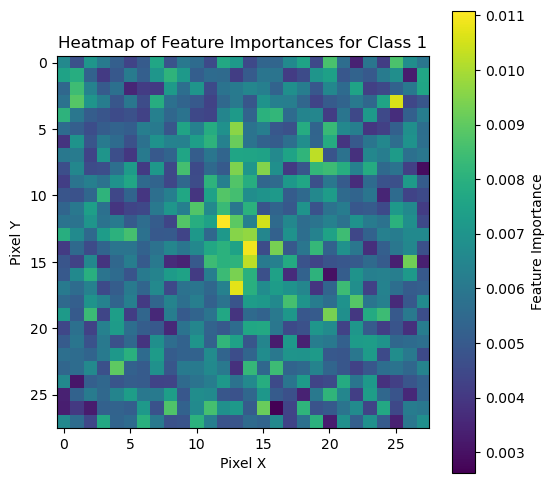

In [212]:
# Plot a simple average of all explanations for "class of interest" given that the actual digit is "class of interest"
class_of_interest = 1
target_indices = y_sample == class_of_interest
# Compute mean explanation for the class across all samples
mean_explanation = np.mean(exp[target_indices,:], axis=0)

# Reshape to 28x28
heatmap_data = mean_explanation.reshape(28, 28)

# Plot the heatmap
plt.figure(figsize=(6, 6))
plt.imshow(heatmap_data, cmap='viridis', interpolation='nearest')
plt.colorbar(label='Feature Importance')
plt.title(f'Heatmap of Feature Importances for Class {class_of_interest}')
plt.xlabel('Pixel X')
plt.ylabel('Pixel Y')
plt.show()

In [217]:
global_exp = compute_Lime_global(X, X_perturbed, fn, y_sample)

0
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
2
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
3
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
4
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
6
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
7
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
8
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
9
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
11
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
12
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
13
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
14
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
15
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
16
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
17
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
18
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
19
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
21
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
22
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
23
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
2

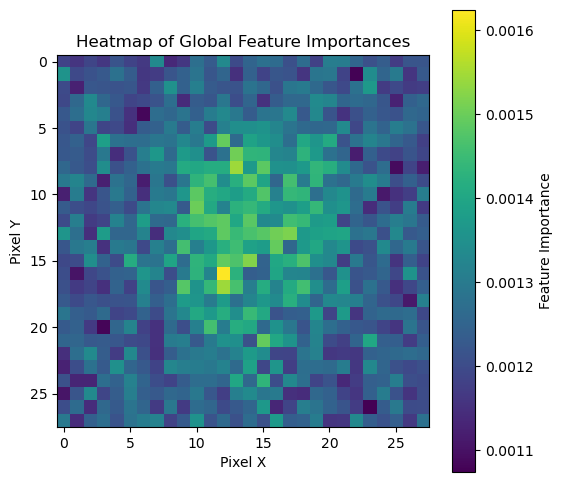

In [328]:
# Reshape to 28x28
heatmap_global = global_exp.reshape(28, 28)

# Plot the heatmap
plt.figure(figsize=(6, 6))
plt.imshow(heatmap_global, cmap='viridis', interpolation='nearest')
plt.colorbar(label='Feature Importance')
plt.title('Heatmap of Global Feature Importances')
plt.xlabel('Pixel X')
plt.ylabel('Pixel Y')
plt.show()

In [225]:
# Save explanations as csvs
df = pd.DataFrame(heatmap_global)

# Save to CSV
df.to_csv('global.csv', index=False, header=True)

In [232]:
for i in range(10):
    class_of_interest = i
    target_indices = y_sample == class_of_interest
    # Compute mean explanation for the first class across all samples
    mean_explanations = np.mean(exp[target_indices,:], axis=0).reshape(28, 28)
    df = pd.DataFrame(mean_explanations)

    # Save to CSV
    df.to_csv(f'simple{i}.csv', index=False, header=True)

In [317]:
# Generate multiple models, iteretively removing more features in ascending order of importance
importances = pd.read_csv("global.csv")
sorted_indices = np.argsort(importances, axis = None)

accuracies = []
X_copy = np.copy(x_train)
for i,p in enumerate(np.linspace(0,1,21)):
    print(i)
    
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28,28, 1)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dense(10, activation='softmax')
    ])

    model.summary()

    model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

    

    model.fit(X_copy, y_train, epochs=5, validation_split=0.1)

    test_loss, test_accuracy = model.evaluate(x_test, y_test)
    accuracies.append(test_accuracy)
    del model
    
    mask = importances>np.quantile(importances,p)
    mask_array = mask.to_numpy()
    replicated_mask = np.tile(mask_array[:, :, np.newaxis], (60000, 1, 1, 1))
    X_copy = X_copy * replicated_mask
    

0


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_41"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_123 (Conv2D)             │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_82 (MaxPooling2D) │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_124 (Conv2D)             │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_83 (MaxPooling2D) │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_125 (Conv2D)             │ (None, 3, 3, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_41 (Flatten)            │ (None, 576)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_82 (Dense)                │ (None, 64)             │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_83 (Dense)                │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 93,322 (364.54 KB)

 Trainable params: 93,322 (364.54 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.8860 - loss: 0.3630 - val_accuracy: 0.9853 - val_loss: 0.0484
Epoch 2/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.9850 - loss: 0.0480 - val_accuracy: 0.9895 - val_loss: 0.0357
Epoch 3/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.9892 - loss: 0.0338 - val_accuracy: 0.9878 - val_loss: 0.0457
Epoch 4/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.9920 - loss: 0.0253 - val_accuracy: 0.9873 - val_loss: 0.0459
Epoch 5/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.9947 - loss: 0.0181 - val_accuracy: 0.9903 - val_loss: 0.0344
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9904 - loss: 0.0321
1


Model: "sequential_42"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_126 (Conv2D)             │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_84 (MaxPooling2D) │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_127 (Conv2D)             │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_85 (MaxPooling2D) │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_128 (Conv2D)             │ (None, 3, 3, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_42 (Flatten)            │ (None, 576)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_84 (Dense)                │ (None, 64)             │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_85 (Dense)                │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 93,322 (364.54 KB)

 Trainable params: 93,322 (364.54 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.8946 - loss: 0.3341 - val_accuracy: 0.9815 - val_loss: 0.0622
Epoch 2/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.9842 - loss: 0.0504 - val_accuracy: 0.9865 - val_loss: 0.0434
Epoch 3/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.9897 - loss: 0.0327 - val_accuracy: 0.9898 - val_loss: 0.0350
Epoch 4/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.9922 - loss: 0.0228 - val_accuracy: 0.9910 - val_loss: 0.0310
Epoch 5/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.9941 - loss: 0.0178 - val_accuracy: 0.9882 - val_loss: 0.0382
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9870 - loss: 0.0444
2


Model: "sequential_43"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_129 (Conv2D)             │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_86 (MaxPooling2D) │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_130 (Conv2D)             │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_87 (MaxPooling2D) │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_131 (Conv2D)             │ (None, 3, 3, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_43 (Flatten)            │ (None, 576)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_86 (Dense)                │ (None, 64)             │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_87 (Dense)                │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 93,322 (364.54 KB)

 Trainable params: 93,322 (364.54 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.8794 - loss: 0.3795 - val_accuracy: 0.9802 - val_loss: 0.0679
Epoch 2/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.9816 - loss: 0.0551 - val_accuracy: 0.9888 - val_loss: 0.0391
Epoch 3/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.9877 - loss: 0.0364 - val_accuracy: 0.9897 - val_loss: 0.0370
Epoch 4/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.9904 - loss: 0.0283 - val_accuracy: 0.9900 - val_loss: 0.0370
Epoch 5/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.9933 - loss: 0.0209 - val_accuracy: 0.9878 - val_loss: 0.0425
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9846 - loss: 0.0519
3


Model: "sequential_44"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_132 (Conv2D)             │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_88 (MaxPooling2D) │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_133 (Conv2D)             │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_89 (MaxPooling2D) │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_134 (Conv2D)             │ (None, 3, 3, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_44 (Flatten)            │ (None, 576)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_88 (Dense)                │ (None, 64)             │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_89 (Dense)                │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 93,322 (364.54 KB)

 Trainable params: 93,322 (364.54 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.8860 - loss: 0.3661 - val_accuracy: 0.9835 - val_loss: 0.0551
Epoch 2/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.9858 - loss: 0.0468 - val_accuracy: 0.9902 - val_loss: 0.0371
Epoch 3/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.9894 - loss: 0.0341 - val_accuracy: 0.9890 - val_loss: 0.0360
Epoch 4/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.9924 - loss: 0.0238 - val_accuracy: 0.9902 - val_loss: 0.0353
Epoch 5/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.9944 - loss: 0.0177 - val_accuracy: 0.9908 - val_loss: 0.0330
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9886 - loss: 0.0380
4


Model: "sequential_45"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_135 (Conv2D)             │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_90 (MaxPooling2D) │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_136 (Conv2D)             │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_91 (MaxPooling2D) │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_137 (Conv2D)             │ (None, 3, 3, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_45 (Flatten)            │ (None, 576)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_90 (Dense)                │ (None, 64)             │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_91 (Dense)                │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 93,322 (364.54 KB)

 Trainable params: 93,322 (364.54 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.8813 - loss: 0.3800 - val_accuracy: 0.9857 - val_loss: 0.0504
Epoch 2/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.9825 - loss: 0.0560 - val_accuracy: 0.9867 - val_loss: 0.0441
Epoch 3/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.9886 - loss: 0.0375 - val_accuracy: 0.9868 - val_loss: 0.0442
Epoch 4/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.9916 - loss: 0.0282 - val_accuracy: 0.9895 - val_loss: 0.0375
Epoch 5/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.9928 - loss: 0.0216 - val_accuracy: 0.9905 - val_loss: 0.0369
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9876 - loss: 0.0371
5


Model: "sequential_46"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_138 (Conv2D)             │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_92 (MaxPooling2D) │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_139 (Conv2D)             │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_93 (MaxPooling2D) │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_140 (Conv2D)             │ (None, 3, 3, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_46 (Flatten)            │ (None, 576)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_92 (Dense)                │ (None, 64)             │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_93 (Dense)                │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 93,322 (364.54 KB)

 Trainable params: 93,322 (364.54 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.8809 - loss: 0.3728 - val_accuracy: 0.9810 - val_loss: 0.0650
Epoch 2/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.9837 - loss: 0.0523 - val_accuracy: 0.9862 - val_loss: 0.0416
Epoch 3/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.9895 - loss: 0.0339 - val_accuracy: 0.9888 - val_loss: 0.0395
Epoch 4/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.9911 - loss: 0.0277 - val_accuracy: 0.9900 - val_loss: 0.0385
Epoch 5/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.9934 - loss: 0.0216 - val_accuracy: 0.9908 - val_loss: 0.0343
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9861 - loss: 0.0462
6


Model: "sequential_47"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_141 (Conv2D)             │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_94 (MaxPooling2D) │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_142 (Conv2D)             │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_95 (MaxPooling2D) │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_143 (Conv2D)             │ (None, 3, 3, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_47 (Flatten)            │ (None, 576)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_94 (Dense)                │ (None, 64)             │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_95 (Dense)                │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 93,322 (364.54 KB)

 Trainable params: 93,322 (364.54 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.8788 - loss: 0.3790 - val_accuracy: 0.9875 - val_loss: 0.0473
Epoch 2/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.9839 - loss: 0.0520 - val_accuracy: 0.9858 - val_loss: 0.0424
Epoch 3/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.9894 - loss: 0.0337 - val_accuracy: 0.9870 - val_loss: 0.0497
Epoch 4/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.9920 - loss: 0.0257 - val_accuracy: 0.9907 - val_loss: 0.0317
Epoch 5/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.9942 - loss: 0.0189 - val_accuracy: 0.9900 - val_loss: 0.0396
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9862 - loss: 0.0430
7


Model: "sequential_48"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_144 (Conv2D)             │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_96 (MaxPooling2D) │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_145 (Conv2D)             │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_97 (MaxPooling2D) │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_146 (Conv2D)             │ (None, 3, 3, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_48 (Flatten)            │ (None, 576)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_96 (Dense)                │ (None, 64)             │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_97 (Dense)                │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 93,322 (364.54 KB)

 Trainable params: 93,322 (364.54 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.8839 - loss: 0.3724 - val_accuracy: 0.9830 - val_loss: 0.0587
Epoch 2/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.9819 - loss: 0.0568 - val_accuracy: 0.9827 - val_loss: 0.0603
Epoch 3/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.9883 - loss: 0.0371 - val_accuracy: 0.9883 - val_loss: 0.0402
Epoch 4/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.9903 - loss: 0.0295 - val_accuracy: 0.9895 - val_loss: 0.0389
Epoch 5/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.9940 - loss: 0.0188 - val_accuracy: 0.9875 - val_loss: 0.0449
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9842 - loss: 0.0472
8


Model: "sequential_49"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_147 (Conv2D)             │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_98 (MaxPooling2D) │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_148 (Conv2D)             │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_99 (MaxPooling2D) │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_149 (Conv2D)             │ (None, 3, 3, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_49 (Flatten)            │ (None, 576)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_98 (Dense)                │ (None, 64)             │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_99 (Dense)                │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 93,322 (364.54 KB)

 Trainable params: 93,322 (364.54 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.8816 - loss: 0.3775 - val_accuracy: 0.9855 - val_loss: 0.0499
Epoch 2/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.9821 - loss: 0.0572 - val_accuracy: 0.9825 - val_loss: 0.0575
Epoch 3/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.9870 - loss: 0.0390 - val_accuracy: 0.9892 - val_loss: 0.0395
Epoch 4/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.9915 - loss: 0.0270 - val_accuracy: 0.9867 - val_loss: 0.0513
Epoch 5/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.9934 - loss: 0.0212 - val_accuracy: 0.9897 - val_loss: 0.0360
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9831 - loss: 0.0588
9


Model: "sequential_50"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_150 (Conv2D)             │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_100               │ (None, 13, 13, 32)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_151 (Conv2D)             │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_101               │ (None, 5, 5, 64)       │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_152 (Conv2D)             │ (None, 3, 3, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_50 (Flatten)            │ (None, 576)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_100 (Dense)               │ (None, 64)             │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_101 (Dense)               │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 93,322 (364.54 KB)

 Trainable params: 93,322 (364.54 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.8767 - loss: 0.4007 - val_accuracy: 0.9835 - val_loss: 0.0589
Epoch 2/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.9819 - loss: 0.0586 - val_accuracy: 0.9852 - val_loss: 0.0506
Epoch 3/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.9873 - loss: 0.0400 - val_accuracy: 0.9885 - val_loss: 0.0402
Epoch 4/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.9899 - loss: 0.0297 - val_accuracy: 0.9875 - val_loss: 0.0427
Epoch 5/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.9934 - loss: 0.0219 - val_accuracy: 0.9892 - val_loss: 0.0407
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9879 - loss: 0.0413
10


Model: "sequential_51"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_153 (Conv2D)             │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_102               │ (None, 13, 13, 32)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_154 (Conv2D)             │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_103               │ (None, 5, 5, 64)       │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_155 (Conv2D)             │ (None, 3, 3, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_51 (Flatten)            │ (None, 576)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_102 (Dense)               │ (None, 64)             │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_103 (Dense)               │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 93,322 (364.54 KB)

 Trainable params: 93,322 (364.54 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.8852 - loss: 0.3827 - val_accuracy: 0.9823 - val_loss: 0.0607
Epoch 2/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.9825 - loss: 0.0574 - val_accuracy: 0.9850 - val_loss: 0.0486
Epoch 3/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.9887 - loss: 0.0363 - val_accuracy: 0.9878 - val_loss: 0.0471
Epoch 4/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.9910 - loss: 0.0280 - val_accuracy: 0.9905 - val_loss: 0.0371
Epoch 5/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.9927 - loss: 0.0226 - val_accuracy: 0.9912 - val_loss: 0.0333
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9844 - loss: 0.0491
11


Model: "sequential_52"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_156 (Conv2D)             │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_104               │ (None, 13, 13, 32)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_157 (Conv2D)             │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_105               │ (None, 5, 5, 64)       │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_158 (Conv2D)             │ (None, 3, 3, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_52 (Flatten)            │ (None, 576)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_104 (Dense)               │ (None, 64)             │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_105 (Dense)               │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 93,322 (364.54 KB)

 Trainable params: 93,322 (364.54 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.8751 - loss: 0.3895 - val_accuracy: 0.9817 - val_loss: 0.0615
Epoch 2/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.9809 - loss: 0.0608 - val_accuracy: 0.9882 - val_loss: 0.0419
Epoch 3/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.9876 - loss: 0.0393 - val_accuracy: 0.9870 - val_loss: 0.0511
Epoch 4/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.9902 - loss: 0.0296 - val_accuracy: 0.9872 - val_loss: 0.0412
Epoch 5/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.9925 - loss: 0.0229 - val_accuracy: 0.9848 - val_loss: 0.0538
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9869 - loss: 0.0419
12


Model: "sequential_53"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_159 (Conv2D)             │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_106               │ (None, 13, 13, 32)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_160 (Conv2D)             │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_107               │ (None, 5, 5, 64)       │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_161 (Conv2D)             │ (None, 3, 3, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_53 (Flatten)            │ (None, 576)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_106 (Dense)               │ (None, 64)             │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_107 (Dense)               │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 93,322 (364.54 KB)

 Trainable params: 93,322 (364.54 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.8724 - loss: 0.4042 - val_accuracy: 0.9772 - val_loss: 0.0744
Epoch 2/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.9813 - loss: 0.0585 - val_accuracy: 0.9867 - val_loss: 0.0443
Epoch 3/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.9871 - loss: 0.0417 - val_accuracy: 0.9832 - val_loss: 0.0578
Epoch 4/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.9897 - loss: 0.0327 - val_accuracy: 0.9882 - val_loss: 0.0446
Epoch 5/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.9925 - loss: 0.0228 - val_accuracy: 0.9902 - val_loss: 0.0387
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9880 - loss: 0.0425
13


Model: "sequential_54"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_162 (Conv2D)             │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_108               │ (None, 13, 13, 32)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_163 (Conv2D)             │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_109               │ (None, 5, 5, 64)       │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_164 (Conv2D)             │ (None, 3, 3, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_54 (Flatten)            │ (None, 576)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_108 (Dense)               │ (None, 64)             │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_109 (Dense)               │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 93,322 (364.54 KB)

 Trainable params: 93,322 (364.54 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.8775 - loss: 0.3823 - val_accuracy: 0.9790 - val_loss: 0.0669
Epoch 2/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.9795 - loss: 0.0655 - val_accuracy: 0.9862 - val_loss: 0.0513
Epoch 3/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.9869 - loss: 0.0425 - val_accuracy: 0.9867 - val_loss: 0.0493
Epoch 4/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.9889 - loss: 0.0324 - val_accuracy: 0.9857 - val_loss: 0.0555
Epoch 5/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.9917 - loss: 0.0245 - val_accuracy: 0.9878 - val_loss: 0.0459
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9854 - loss: 0.0490
14


Model: "sequential_55"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_165 (Conv2D)             │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_110               │ (None, 13, 13, 32)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_166 (Conv2D)             │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_111               │ (None, 5, 5, 64)       │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_167 (Conv2D)             │ (None, 3, 3, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_55 (Flatten)            │ (None, 576)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_110 (Dense)               │ (None, 64)             │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_111 (Dense)               │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 93,322 (364.54 KB)

 Trainable params: 93,322 (364.54 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.8672 - loss: 0.4269 - val_accuracy: 0.9813 - val_loss: 0.0661
Epoch 2/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.9798 - loss: 0.0647 - val_accuracy: 0.9843 - val_loss: 0.0553
Epoch 3/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.9862 - loss: 0.0431 - val_accuracy: 0.9857 - val_loss: 0.0482
Epoch 4/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.9901 - loss: 0.0315 - val_accuracy: 0.9840 - val_loss: 0.0524
Epoch 5/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.9923 - loss: 0.0240 - val_accuracy: 0.9845 - val_loss: 0.0606
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9801 - loss: 0.0595
15


Model: "sequential_56"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_168 (Conv2D)             │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_112               │ (None, 13, 13, 32)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_169 (Conv2D)             │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_113               │ (None, 5, 5, 64)       │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_170 (Conv2D)             │ (None, 3, 3, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_56 (Flatten)            │ (None, 576)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_112 (Dense)               │ (None, 64)             │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_113 (Dense)               │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 93,322 (364.54 KB)

 Trainable params: 93,322 (364.54 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.8610 - loss: 0.4352 - val_accuracy: 0.9765 - val_loss: 0.0767
Epoch 2/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.9783 - loss: 0.0731 - val_accuracy: 0.9822 - val_loss: 0.0597
Epoch 3/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.9838 - loss: 0.0522 - val_accuracy: 0.9820 - val_loss: 0.0666
Epoch 4/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.9887 - loss: 0.0374 - val_accuracy: 0.9842 - val_loss: 0.0559
Epoch 5/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.9905 - loss: 0.0288 - val_accuracy: 0.9847 - val_loss: 0.0576
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9856 - loss: 0.0459
16


Model: "sequential_57"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_171 (Conv2D)             │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_114               │ (None, 13, 13, 32)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_172 (Conv2D)             │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_115               │ (None, 5, 5, 64)       │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_173 (Conv2D)             │ (None, 3, 3, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_57 (Flatten)            │ (None, 576)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_114 (Dense)               │ (None, 64)             │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_115 (Dense)               │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 93,322 (364.54 KB)

 Trainable params: 93,322 (364.54 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.8594 - loss: 0.4490 - val_accuracy: 0.9755 - val_loss: 0.0799
Epoch 2/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.9737 - loss: 0.0838 - val_accuracy: 0.9813 - val_loss: 0.0624
Epoch 3/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.9819 - loss: 0.0566 - val_accuracy: 0.9825 - val_loss: 0.0597
Epoch 4/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.9866 - loss: 0.0422 - val_accuracy: 0.9837 - val_loss: 0.0525
Epoch 5/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.9887 - loss: 0.0352 - val_accuracy: 0.9855 - val_loss: 0.0466
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9814 - loss: 0.0582
17


Model: "sequential_58"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_174 (Conv2D)             │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_116               │ (None, 13, 13, 32)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_175 (Conv2D)             │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_117               │ (None, 5, 5, 64)       │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_176 (Conv2D)             │ (None, 3, 3, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_58 (Flatten)            │ (None, 576)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_116 (Dense)               │ (None, 64)             │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_117 (Dense)               │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 93,322 (364.54 KB)

 Trainable params: 93,322 (364.54 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.8562 - loss: 0.4658 - val_accuracy: 0.9672 - val_loss: 0.1093
Epoch 2/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.9708 - loss: 0.0916 - val_accuracy: 0.9765 - val_loss: 0.0786
Epoch 3/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.9801 - loss: 0.0633 - val_accuracy: 0.9803 - val_loss: 0.0660
Epoch 4/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.9842 - loss: 0.0491 - val_accuracy: 0.9850 - val_loss: 0.0554
Epoch 5/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.9870 - loss: 0.0388 - val_accuracy: 0.9853 - val_loss: 0.0564
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9798 - loss: 0.0674
18


Model: "sequential_59"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_177 (Conv2D)             │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_118               │ (None, 13, 13, 32)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_178 (Conv2D)             │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_119               │ (None, 5, 5, 64)       │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_179 (Conv2D)             │ (None, 3, 3, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_59 (Flatten)            │ (None, 576)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_118 (Dense)               │ (None, 64)             │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_119 (Dense)               │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 93,322 (364.54 KB)

 Trainable params: 93,322 (364.54 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - accuracy: 0.8365 - loss: 0.5183 - val_accuracy: 0.9663 - val_loss: 0.1121
Epoch 2/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.9657 - loss: 0.1098 - val_accuracy: 0.9722 - val_loss: 0.0936
Epoch 3/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.9753 - loss: 0.0773 - val_accuracy: 0.9772 - val_loss: 0.0758
Epoch 4/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.9790 - loss: 0.0627 - val_accuracy: 0.9763 - val_loss: 0.0785
Epoch 5/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.9840 - loss: 0.0486 - val_accuracy: 0.9763 - val_loss: 0.0801
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9586 - loss: 0.1315
19


Model: "sequential_60"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_180 (Conv2D)             │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_120               │ (None, 13, 13, 32)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_181 (Conv2D)             │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_121               │ (None, 5, 5, 64)       │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_182 (Conv2D)             │ (None, 3, 3, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_60 (Flatten)            │ (None, 576)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_120 (Dense)               │ (None, 64)             │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_121 (Dense)               │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 93,322 (364.54 KB)

 Trainable params: 93,322 (364.54 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - accuracy: 0.8092 - loss: 0.5846 - val_accuracy: 0.9570 - val_loss: 0.1466
Epoch 2/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.9513 - loss: 0.1539 - val_accuracy: 0.9635 - val_loss: 0.1222
Epoch 3/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.9622 - loss: 0.1137 - val_accuracy: 0.9652 - val_loss: 0.1171
Epoch 4/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.9680 - loss: 0.0968 - val_accuracy: 0.9678 - val_loss: 0.1088
Epoch 5/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.9738 - loss: 0.0794 - val_accuracy: 0.9698 - val_loss: 0.0966
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9271 - loss: 0.2273
20


Model: "sequential_61"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_183 (Conv2D)             │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_122               │ (None, 13, 13, 32)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_184 (Conv2D)             │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_123               │ (None, 5, 5, 64)       │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_185 (Conv2D)             │ (None, 3, 3, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_61 (Flatten)            │ (None, 576)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_122 (Dense)               │ (None, 64)             │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_123 (Dense)               │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 93,322 (364.54 KB)

 Trainable params: 93,322 (364.54 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.7481 - loss: 0.7626 - val_accuracy: 0.9087 - val_loss: 0.2986
Epoch 2/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.8996 - loss: 0.3103 - val_accuracy: 0.9183 - val_loss: 0.2584
Epoch 3/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.9146 - loss: 0.2597 - val_accuracy: 0.9253 - val_loss: 0.2335
Epoch 4/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.9290 - loss: 0.2200 - val_accuracy: 0.9382 - val_loss: 0.2097
Epoch 5/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.9343 - loss: 0.2000 - val_accuracy: 0.9415 - val_loss: 0.1981
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7884 - loss: 0.6664


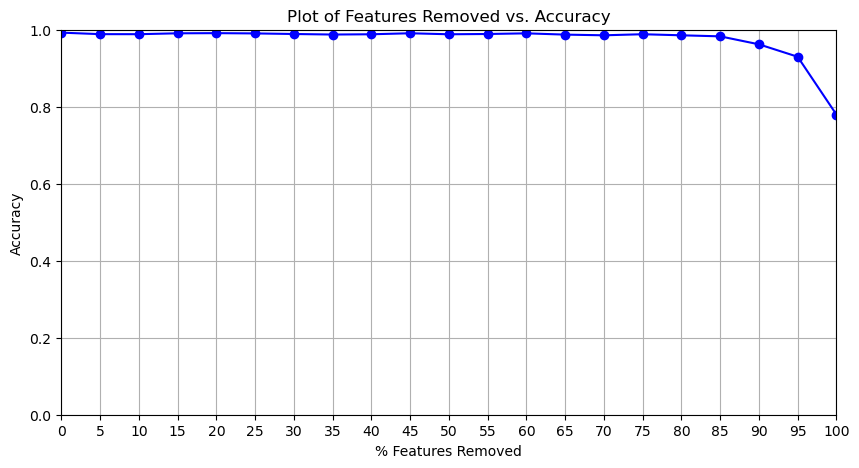

In [327]:
x_labels = np.arange(0, 105, 5)
plt.figure(figsize=(10, 5))  # Set the size of the plot
plt.plot(accuracies, marker='o', linestyle='-', color='b')  # Adds markers for each point
plt.title('Plot of Features Removed vs. Accuracy')
plt.xlabel('% Features Removed')
plt.ylabel('Accuracy')
plt.ylim(0, 1)  # Full y-axis range from 0 to 1
plt.xlim(0, len(accuracies) - 1)  # Limits ensure indices map correctly
plt.xticks(ticks=np.linspace(0, len(accuracies) - 1, len(x_labels)), labels=x_labels)
plt.grid(True)  # Add grid for better readability
plt.show()